# Predicting Order Cancellations and Returns

## Introduction
This notebook outlines the process of building a machine learning pipeline to predict whether **DELIVERED** and **IN PROCESS** orders will be **CANCELLED** or **RETURNED**. The objective is to help businesses identify potential cancellations or returns based on historical data, allowing them to manage inventory and customer service more efficiently. We will use a **Random Forest** classifier with **GridSearchCV** for hyperparameter tuning and **threshold tuning** to optimize model performance and reduce false negatives.

## Steps Involved

### 1. Data Preprocessing
The initial phase involves cleaning and preparing the raw data for modeling:
- **Filtering Relevant Orders**: We filter the dataset to include orders with statuses `DELIVERED`, `IN PROCESS`, `CANCELLED`, or `RETURNED`.
- **Target Variable Creation**: A binary target is created, where `CANCELLED` and `RETURNED` orders are assigned the value `1`, and `DELIVERED` and `IN PROCESS` orders are assigned the value `0`.
- **Handling Missing Values and Encoding**:
  - **Numerical Data**: Missing numerical values are imputed using the mean, and the data is scaled using `StandardScaler`.
  - **Categorical Data**: Categorical variables are encoded using one-hot encoding to ensure compatibility with the model.

This preprocessing step prepares the data for machine learning.

### 2. Model Training and Hyperparameter Tuning
We will train a **Random Forest** classifier using the preprocessed data:
- **Class Weighting**: To deal with the class imbalance (more DELIVERED and IN PROCESS orders), we assign weights to the classes to penalize the model for missing `CANCELLED` or `RETURNED` orders.
- **GridSearchCV**: We'll use `GridSearchCV` to optimize hyperparameters such as `n_estimators`, `max_depth`, and `min_samples_split`, ensuring the model is robust and performs well on unseen data.

### 3. Threshold Tuning for Improved Predictions
After training the model, we will adjust the classification threshold to fine-tune the model's predictions:
- **Adjusting the Classification Threshold**: We experiment with different thresholds (from 0.1 to 0.9) to select the one that optimizes the **F1-score**.
- **F1-Score vs Threshold Plot**: A plot will be generated to visualize how different thresholds impact the F1-score. This allows us to choose a threshold that balances precision and recall, minimizing false negatives.

### 4. Model Evaluation
The model will be evaluated using the following metrics:
- **Confusion Matrix**: This matrix will give insights into true positives, false positives, true negatives, and false negatives.
- **Precision, Recall, and F1-Score**: We'll visualize these metrics using bar plots to understand the model's performance across different classes.
- **ROC and Precision-Recall Curves**:
  - **ROC Curve**: The ROC curve shows the trade-off between true positive rate (recall) and false positive rate. We'll compute the **AUC** (Area Under the Curve) for a single metric summary.
  - **Precision-Recall Curve**: This curve will show the relationship between precision and recall at different thresholds.

### 5. Predictions on DELIVERED and IN PROCESS Orders
Once the model is tuned and the best threshold is determined:
- **Predicting DELIVERED and IN PROCESS Orders**: We'll use the model to predict which `DELIVERED` and `IN PROCESS` orders are likely to be canceled or returned. This helps businesses manage these orders proactively, improving inventory and customer management.

### 6. Model Refinement
To further refine the model:
- **Adding More Features**: We can introduce additional features such as customer history, product category, and purchase time to improve accuracy.
- **Handling Class Imbalance**: Techniques like **SMOTE** can be employed to address the imbalance in the dataset and improve prediction performance.

## Model Patterns: Random Forest & Threshold Tuning

- **Random Forest**: A tree-based ensemble learning method that captures complex feature interactions to identify patterns leading to cancellations or returns.
- **Threshold Tuning**:
  - Adjusts the classification boundary based on predicted probabilities.
  - Optimizes the trade-off between precision (minimizing false positives) and recall (minimizing false negatives).
  - **F1-Score**: A key metric that balances precision and recall, especially useful for imbalanced datasets.

## Procedure Summary
This notebook outlines the steps to:
1. **Preprocess** the raw order data into a binary classification problem.
2. **Train** a Random Forest model with hyperparameter tuning using `GridSearchCV` and class weights.
3. **Tune the classification threshold** to minimize false negatives, especially for canceled and returned orders.
4. **Evaluate the model** using performance metrics and visualization tools.
5. **Predict cancellations and returns** for `DELIVERED` and `IN PROCESS` orders, enabling proactive business decisions to minimize losses from returns or cancellations.


# Package Installation for Snowflake Connection and Data Processing

In [ ]:
# The libraries include Snowflake connectors, data processing, machine learning, and visualization tools

!pip install  snowflake  snowflake-connector-python snowflake-snowpark-python snowflake-snowpark-python[pandas] seaborn matplotlib numpy pandas scikit-learn  fosforml plotly

# Import essential libraries

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import seaborn as sns  # For data visualization
from datetime import datetime  # To handle date and time data
import matplotlib.pyplot as plt  # For plotting static visualizations
from sklearn.preprocessing import StandardScaler  # For scaling numerical features
import time  # To measure time and performance
from snowflake.snowpark.session import Session  # For Snowflake data connection and session management
from plotly.subplots import make_subplots  # For creating subplots in Plotly
import plotly.graph_objects as go  # To create interactive Plotly visualizations

# Configure pandas to display more columns for better inspection of data
pd.set_option('display.max_columns', 100)

# This section connects to Snowflake using **fosforml's Snowflake session manager**, retrieves data from a specified Snowflake table, and loads the data into a Pandas DataFrame for further processing and modeling.


In [4]:
# Import the get_session function from fosforml's Snowflake session manager
# This function helps in establishing a Snowflake session for executing queries
from fosforml.model_manager.snowflakesession import get_session

# Establish a Snowflake session using the configured session manager
# The session will allow you to execute SQL queries and retrieve data from Snowflake
my_session = get_session()

#  Define the name of the table you want to query from Snowflake
# This table should contain the data for order statuses, including DELIVERED, IN PROCESS, CANCELLED, and RETURNED orders
table_name = 'ORDER_DATA_ML'

#  Execute a SQL query to select all records from the specified Snowflake table
# The data is retrieved from Snowflake and loaded into a Pandas DataFrame for further processing
df = my_session.sql(f"SELECT * FROM {table_name}").to_pandas()

# Display the first few rows of the retrieved DataFrame to verify the data load
df.head()


,DIVISION_CODE,DIVISION_NAME,BRAND_CODE,BRAND_NAME,CLASS_CODE,CLASS_NAME,SELLING_CHANNEL,CHAIN,WEB_ORDER_NUMBER,OMS_ORDER_NUMBER,OMS_LINE_ITEM_ID,OMS_TICKET_ID,SKU_ID,QUANTITY,UNIT_PRICE,CURRENT_STATUS,CURRENT_STATUS_DESCRIPTION,TRANSACTION_DATE,SHIP_FROM_WAREHOUSE_CODE,SHIP_FROM_WAREHOUSE_DESCRIPTION,ORDER_DATE,READY_TO_PRINT_DATE,PRINT_TICKET_DATE,VERIFIED_SHIPPED_DATE,BACK_ORDERED_DATE,ORDER_AGE,GIFT_ARTICLE_FLAG,CARRIER_NAME,CARRIER_TRACKING_NUMBER,DROPSHIP_FLAG,ORDER_STATUS,ORDER_CREATION_DATE,ORDER_CONFIRMATION_DATE,WM_ORDER_ID,WM_ORDER_LINE_ID,WM_ORDER_STATUS,WM_PICKING_START_TIME,WM_PICKING_END_TIME,WM_PICKING_AGE,WM_PACKING_START_TIME,WM_PACKING_END_TIME,WM_PACKING_AGE,WM_CREATED_DATE,WM_UPDATED_DATE,WM_SHIPPED_DATE,WM_ORDER_AGE,STORE_ID,STORE_NAME,SHIP_METHOD_CODE,SHIP_METHOD_NAME,SHIP_METHOD_SERVICE,SHIPMENT_SLA,NEW_ORDER_DATE,RETURN_REASON,RETURN_FLAG,RECORD_DATE,RECORD_TIME,GROSS_SALES,RETURNED_STATUS
0,81,Women's Designer RTW,24422,Khaite,6,Denim,Online,Chain1,WC100004182263,51956479,51956479*2,51956479-2,301236905235,1,408.0,VS,Shipped,07-03-2024,2,Northpark,2024-07-10,2024-03-07 06:02:18,2024-03-07 06:16:22,2024-03-07 18:27:01,None,0,false,FedEx SmartPost,******08155361113886,false,Fulfilled,2024-03-07 06:16:44.510,2024-03-07 06:16:44.553,51956479-21,******8157259087989,Shipped,2024-03-07 07:45:18.127,2024-03-07 12:45:20.378,0.0,2024-03-07 12:44:43.385,2024-03-07 18:02:34.563,0.0,2024-03-07 06:50:15.747,2024-03-07 18:20:37.326,2024-03-07 18:19:07.075,0.0,None,NA,FXPOS,FedEx SmartPost,GROUND,None,2023-07-15,None,Fully Returned,2024-10-01,04:23:00.597000,408,DELIVERED
1,18,Intimate Apparel,12291,Hanro,106,Slips,Store_POS,Chain1,SP0230011004272030324,51915266,51915266*1,51915266-1,301101027338,1,95.0,VS,Shipped,05-03-2024,2,Northpark,2023-05-05,2024-03-03 15:00:51,2024-03-03 16:16:40,2024-03-05 14:39:23,None,2,false,FedEx,******392510,false,Fulfilled,2024-03-03 16:17:34.041,2024-03-03 16:17:34.065,51915266-11,******2776707735174,Shipped,2024-03-03 17:15:28.243,2024-03-04 11:37:34.277,1.0,2024-03-04 11:37:33.706,2024-03-05 14:18:02.183,1.0,2024-03-03 16:51:17.681,2024-03-05 14:35:33.418,2024-03-05 14:34:15.753,2.0,None,NA,FEDXH,FedEx Home Delivery,GROUND,None,2022-09-05,None,None,None,None,95,DELIVERED
2,53,Beauty,14510,ROC,995,GWP's,Online,Chain1,WC100004139570,51884603,51884603*4,51884603-1,301240888869,1,0.0,VS,Shipped,04-03-2024,2,Northpark,2024-05-27,2024-03-02 18:34:43,2024-03-02 19:15:09,2024-03-04 07:41:19,None,2,true,FedEx SmartPost,******08155361015975,false,Fulfilled,2024-03-02 19:15:59.198,2024-03-02 19:15:59.241,51884603-11,******6416082188687,Shipped,2024-03-03 04:47:47.651,2024-03-04 06:23:12.281,1.0,2024-03-04 06:22:25.940,2024-03-04 07:24:41.313,0.0,2024-03-02 19:50:41.624,2024-03-04 07:35:35.015,2024-03-04 07:34:04.119,2.0,None,NA,FXPOS,FedEx SmartPost,GROUND,None,2023-06-18,None,None,None,None,0,DELIVERED
3,18,Intimate Apparel,12291,Hanro,1,Shirts/Tops,Online,Chain1,WC100004176779,51947005,51947005*1,51947005-1,301224599477,1,240.0,VS,Shipped,07-03-2024,2,Northpark,2024-10-25,2024-03-06 11:13:06,2024-03-06 11:17:00,2024-03-07 07:24:39,None,1,false,FedEx SmartPost,******08155361094611,false,Fulfilled,2024-03-06 11:17:54.549,2024-03-06 11:17:54.649,51947005-11,******5231432220836,Shipped,2024-03-06 12:15:22.319,2024-03-06 18:33:34.663,0.0,2024-03-06 18:32:11.086,2024-03-06 22:36:20.716,0.0,2024-03-06 11:52:03.166,2024-03-07 07:20:22.051,2024-03-06 22:49:12.199,0.0,None,NA,FXPOS,FedEx SmartPost,GROUND,None,2022-09-14,None,Fully Returned,2024-10-01,04:23:00.597000,240,DELIVERED
4,53,Beauty,11796,Estee Lauder,995,GWP's,Online,Chain1,WC100004190974,51971715,51971715*2,51971715-2,301238247418,1,0.0,VS,Shipped,09-03-2024,2,Northpark,2024-08-25,2024-03-08 11:25:43,2024-03-08 12:17:08,2024-03-09 11:10:42,None,1,true,FedEx SmartPost,******08155361151543,false,Fulfilled,2024-03-08 12:18:06.080,2024-03-08 12:18:06.117,51971715-21,******8981902098719,Shipped,2024-03-08 13:45:31.626,2024-03-08 21:23:51.280,0.0,

In [5]:
df_sample = df.groupby('RETURNED_STATUS').sample(10000, replace=True)

# Function to display bar and pie charts using Matplotlib and Seaborn

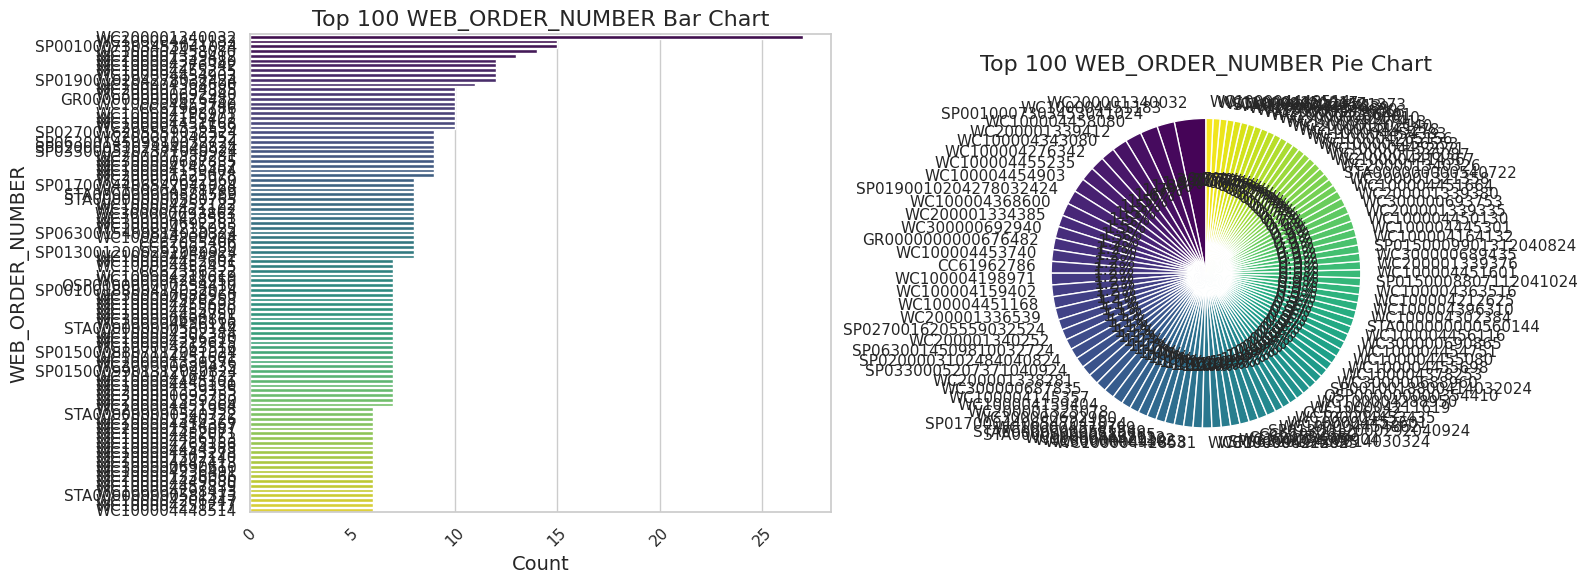

In [6]:
sns.set(style="whitegrid")  # White background with grid lines for better visibility

def display_bar(df, column_name):
    """
    This function takes in a DataFrame and a column name, 
    and visualizes the top 100 values of that column using 
    both a bar chart and a pie chart.

    Args:
    df (pd.DataFrame): DataFrame containing the data
    column_name (str): The column name to visualize
    
    Returns:
    None
    """
    
    # Aggregate data by the column and get the top 100 values
    aggregated_data = df[column_name].value_counts().head(100)
    
    # Extract keys (unique values) and values (counts)
    keys = aggregated_data.index
    values = aggregated_data.values
    
    # Set up the Matplotlib figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 2]})
    
    # Plot the bar chart using Seaborn
    sns.barplot(x=values, y=keys, ax=ax[0], palette='viridis')
    ax[0].set_title(f"Top 100 {column_name} Bar Chart", fontsize=16)
    ax[0].set_xlabel("Count", fontsize=14)
    ax[0].set_ylabel(column_name, fontsize=14)
    ax[0].tick_params(axis='x', rotation=45)
    
    # Plot the pie chart using Matplotlib
    ax[1].pie(values, labels=keys, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(values)))
    ax[1].set_title(f"Top 100 {column_name} Pie Chart", fontsize=16)
    
    # Display the charts
    plt.tight_layout()
    plt.show()

# Call the function to display the bar and pie charts
display_bar(df_sample, 'WEB_ORDER_NUMBER')

Ready to print #cancelled #training columns

1. cancelled
2. Returned
3. Delivered

#  Visualizing Order Status Distribution 

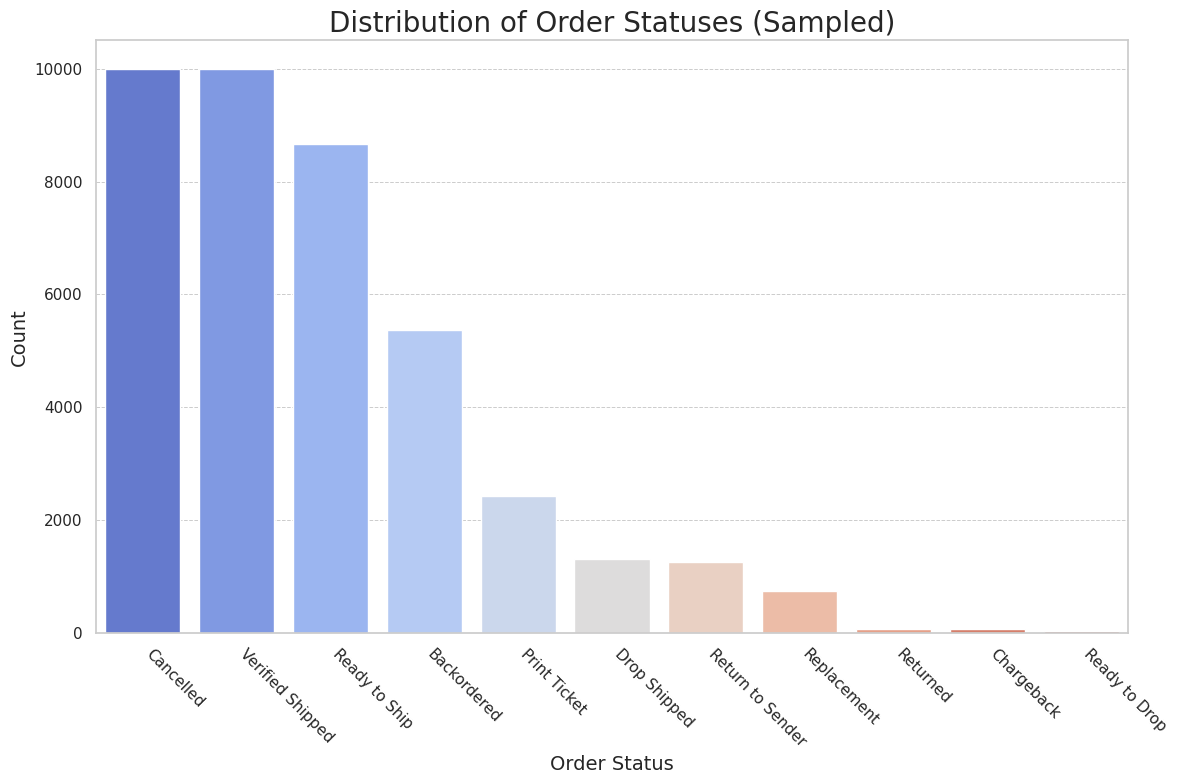

In [7]:
#  Create a dictionary to map status codes to full descriptions
status_map = {
    'VS': 'Verified Shipped', 
    'RT': 'Ready to Ship',
    'CX': 'Cancelled',  # cancelled - for training columns
    'RX': 'Return to Sender',
    'BO': 'Backordered',  # cancelled - for training columns
    'PT': 'Print Ticket',  # cancelled - for training columns
    'DS': 'Drop Shipped', 
    'RN': 'Returned',
    'RP': 'Replacement',
    'CB': 'Chargeback',  # cancelled - for training columns
    'RD': 'Ready to Drop'  # cancelled - for training columns
}

#  Replace status codes in the 'CURRENT_STATUS' column with full forms
df_sample['CURRENT_STATUS'] = df_sample['CURRENT_STATUS'].replace(status_map)

#  Aggregate the count of each order status
status_counts = df_sample['CURRENT_STATUS'].value_counts().reset_index()
status_counts.columns = ['CURRENT_STATUS', 'Count']

# Set Seaborn theme for better visuals
sns.set(style="whitegrid")

#  Set figure size for a large and clear visualization
plt.figure(figsize=(12, 8))

# Create a bar plot using Seaborn for the distribution of order statuses
ax = sns.barplot(
    x='CURRENT_STATUS', 
    y='Count', 
    data=status_counts, 
    palette='coolwarm'
)

#  Add titles and labels to the plot
plt.title('Distribution of Order Statuses (Sampled)', fontsize=20)
plt.xlabel('Order Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

#  Rotate x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Add gridlines to make the plot more readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)

#  Adjust margins to ensure everything fits within the plot
plt.tight_layout()

# Show the plot
plt.show()

# Visualizing Order Age Distribution

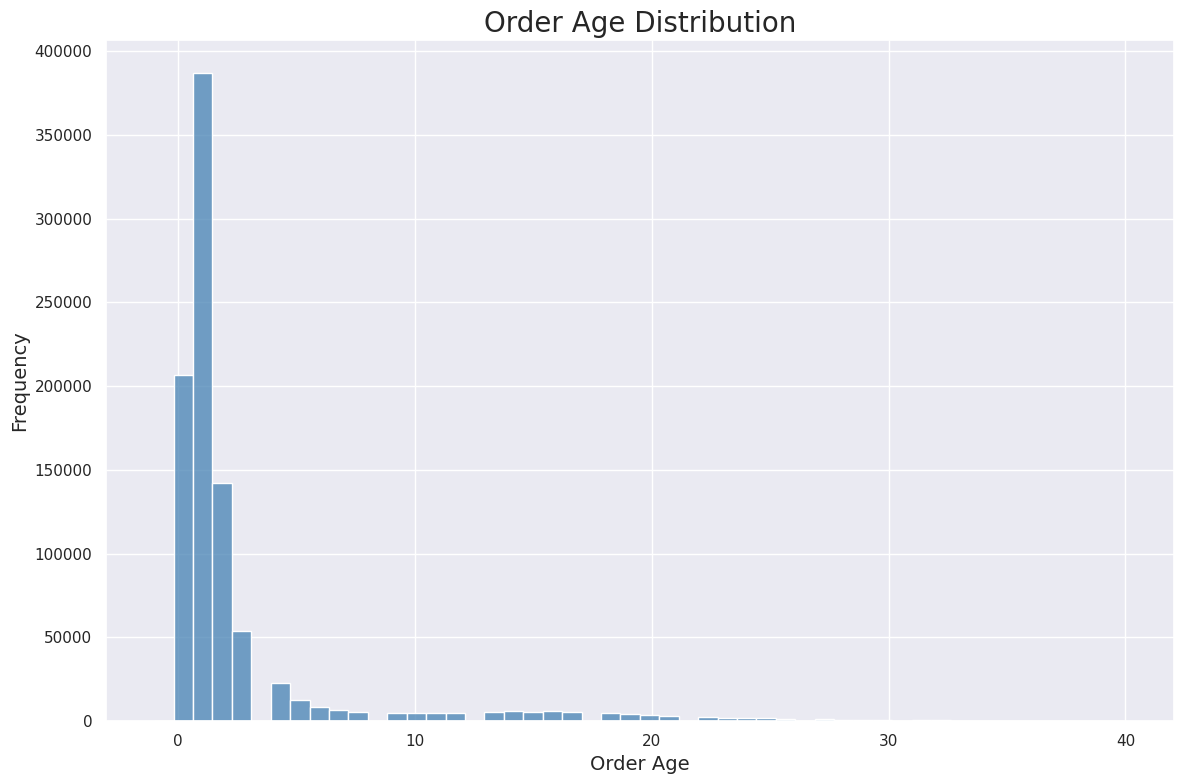

In [8]:
# Set Seaborn style for better visuals
sns.set(style="darkgrid")

#  Create a figure and adjust its size
plt.figure(figsize=(12, 8))

# Plot the histogram using Seaborn's distplot (or histplot for newer versions)
sns.histplot(
    df['ORDER_AGE'], 
    bins=50,  # Set the number of bins to 50
    kde=False,  # Disable kernel density estimate for a pure histogram
    color='steelblue'
)

#  Add titles and labels to the histogram
plt.title('Order Age Distribution', fontsize=20)
plt.xlabel('Order Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

#  Display the plot
plt.tight_layout()  # Ensure everything fits within the plot area
plt.show()

# Order Status Distribution by Channel

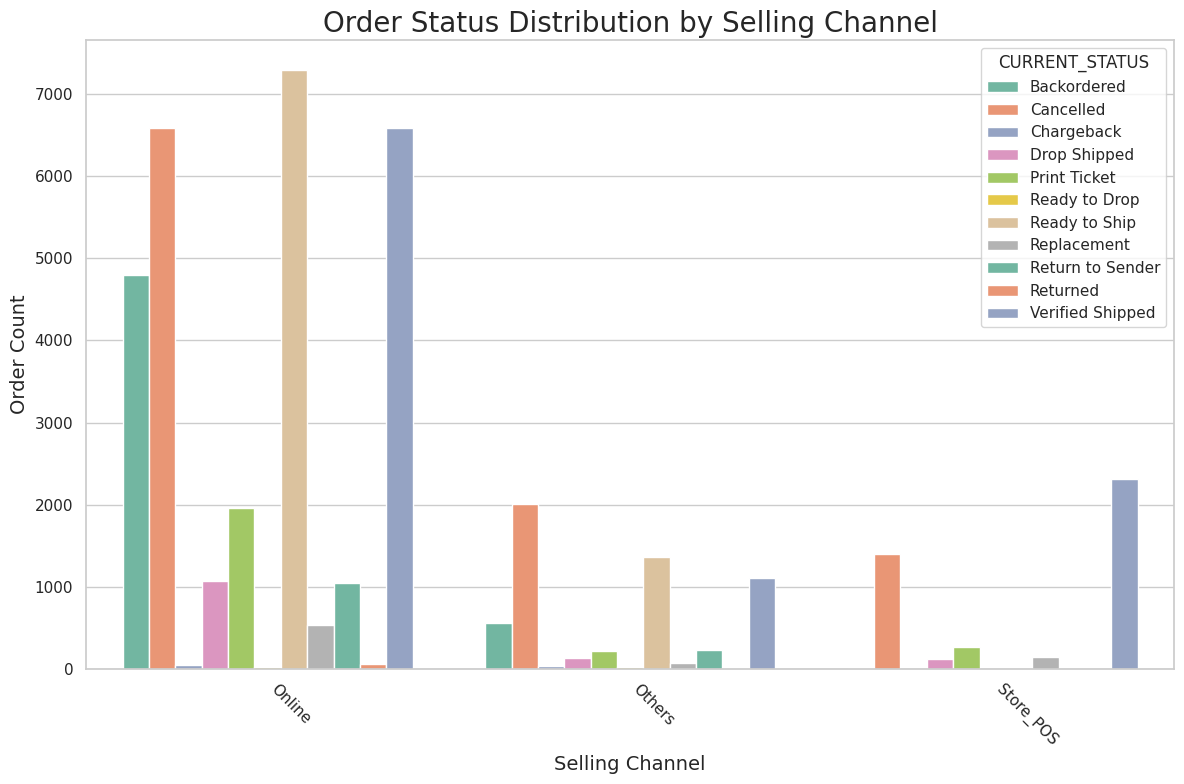

In [9]:
#  Group the data by 'SELLING_CHANNEL' and 'CURRENT_STATUS' and count the occurrences
channel_status_counts = df_sample.groupby(['SELLING_CHANNEL', 'CURRENT_STATUS']).size().reset_index(name='Count')

# Set the style and figure size for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create a grouped bar plot using Seaborn
ax = sns.barplot(
    data=channel_status_counts,
    x='SELLING_CHANNEL',
    y='Count',
    hue='CURRENT_STATUS',  # Use 'CURRENT_STATUS' to color the bars
    palette='Set2'  # Choose a color palette for better contrast
)

# Add titles and axis labels to the plot
plt.title('Order Status Distribution by Selling Channel', fontsize=20)
plt.xlabel('Selling Channel', fontsize=14)
plt.ylabel('Order Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to avoid overlapping
plt.tight_layout()

#  Display the plot
plt.show()

# Order Age Analysis by Status

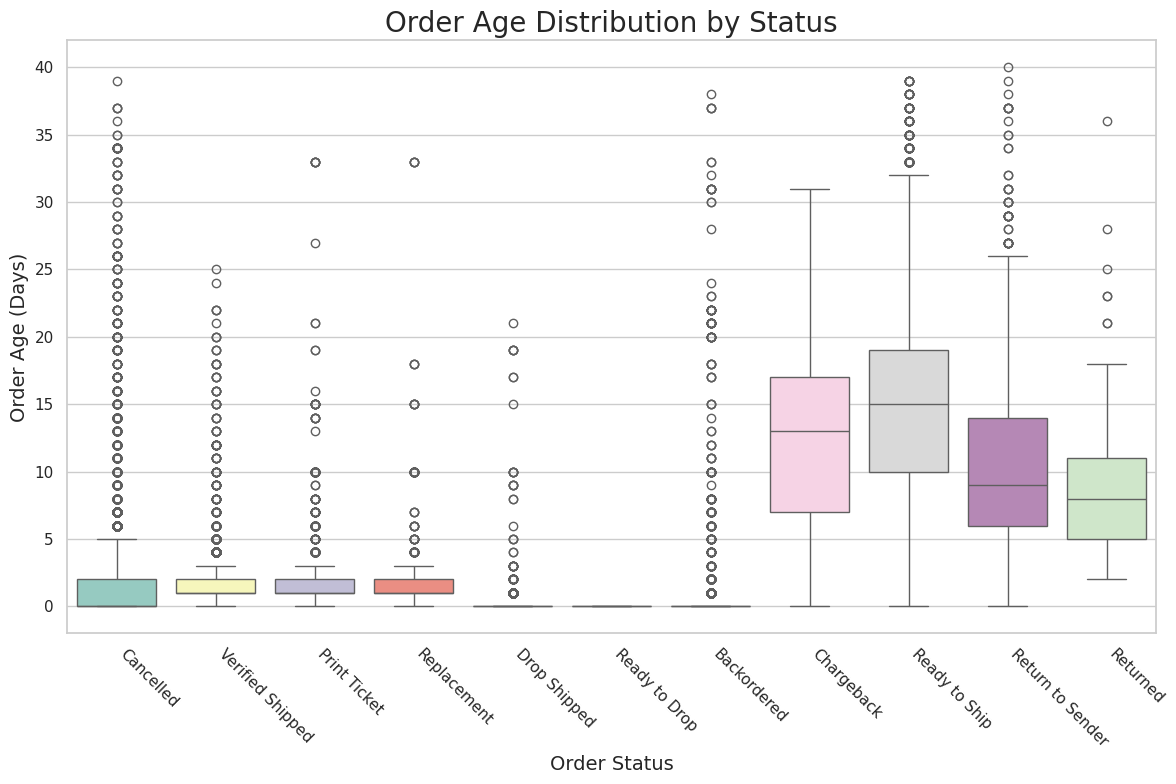

In [10]:

# Set the Seaborn style for better visuals
sns.set(style="whitegrid")

#  Create a figure with a custom size
plt.figure(figsize=(12, 8))

#  Create a box plot using Seaborn
sns.boxplot(
    data=df_sample, 
    x='CURRENT_STATUS', 
    y='ORDER_AGE', 
    palette='Set3'  # Use a custom color palette for visual appeal
)

#  Add titles and labels to the plot
plt.title('Order Age Distribution by Status', fontsize=20)
plt.xlabel('Order Status', fontsize=14)
plt.ylabel('Order Age (Days)', fontsize=14)

#  Rotate x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()

# Order Processing Time Analysis

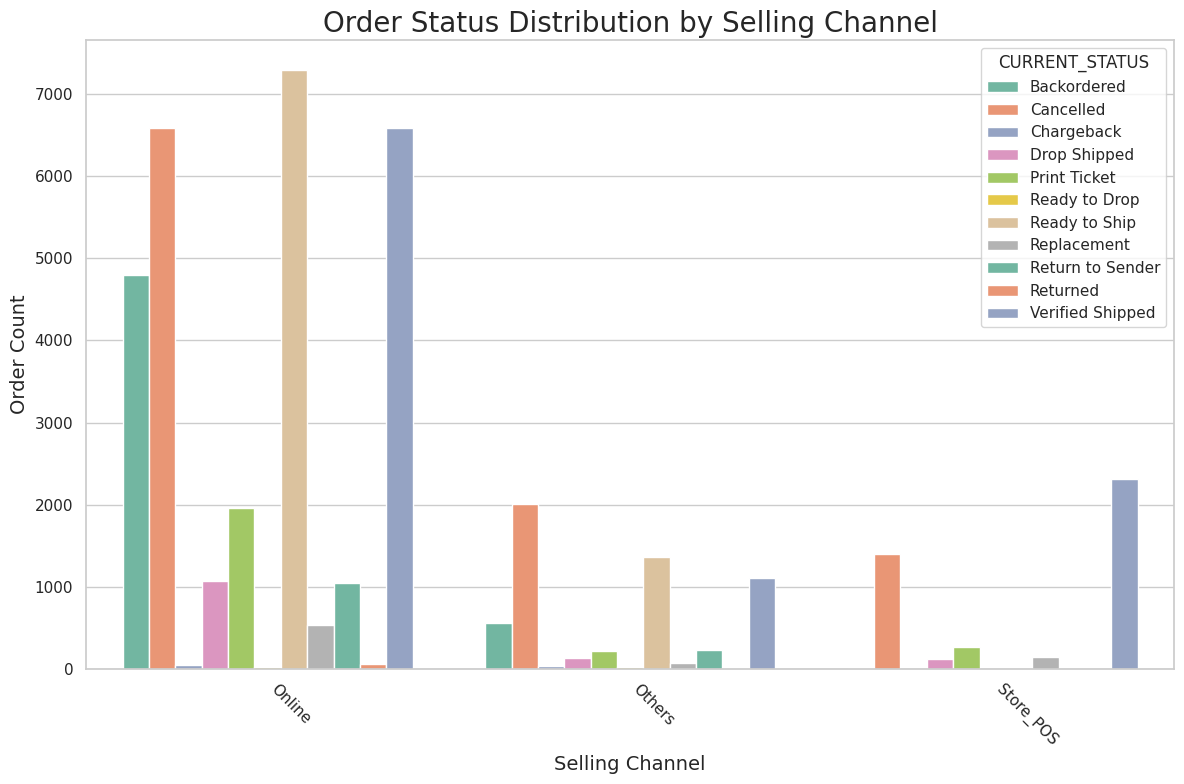

In [11]:
#  Group the data by 'SELLING_CHANNEL' and 'CURRENT_STATUS' and count the occurrences
channel_status_counts = df_sample.groupby(['SELLING_CHANNEL', 'CURRENT_STATUS']).size().reset_index(name='Count')

#  Set the style and figure size for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

#  Create a grouped bar plot using Seaborn
ax = sns.barplot(
    data=channel_status_counts,
    x='SELLING_CHANNEL',
    y='Count',
    hue='CURRENT_STATUS',  # Use 'CURRENT_STATUS' to color the bars
    palette='Set2'  # Choose a color palette for better contrast
)

#  Add titles and axis labels to the plot
plt.title('Order Status Distribution by Selling Channel', fontsize=20)
plt.xlabel('Selling Channel', fontsize=14)
plt.ylabel('Order Count', fontsize=14)

#  Rotate x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to avoid overlapping
plt.tight_layout()

#  Display the plot
plt.show()

# Order Processing Time Analysis

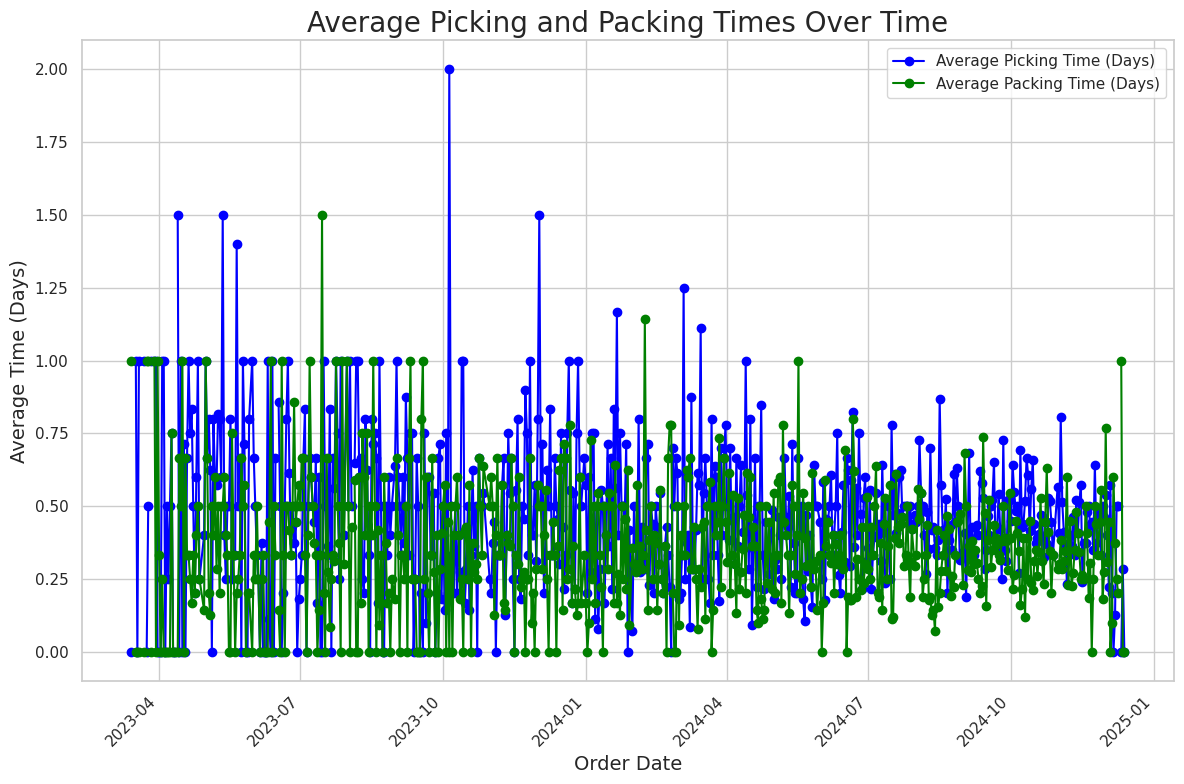

In [12]:


#  Calculate the average picking and packing times grouped by order date
processing_time = df_sample.groupby('ORDER_DATE')[['WM_PICKING_AGE', 'WM_PACKING_AGE']].mean().reset_index()

# Set Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Set up the figure size for better visibility
plt.figure(figsize=(12, 8))

#  Plot the line plot for WM_PICKING_AGE
plt.plot(
    processing_time['ORDER_DATE'], 
    processing_time['WM_PICKING_AGE'], 
    label='Average Picking Time (Days)', 
    color='blue', 
    marker='o'
)

#  Plot the line plot for WM_PACKING_AGE
plt.plot(
    processing_time['ORDER_DATE'], 
    processing_time['WM_PACKING_AGE'], 
    label='Average Packing Time (Days)', 
    color='green', 
    marker='o'
)

#  Add titles and axis labels to the plot
plt.title('Average Picking and Packing Times Over Time', fontsize=20)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Average Time (Days)', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

#  Add a legend to differentiate between picking and packing times
plt.legend()

#  Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


# Total Revenue by Selling Channel

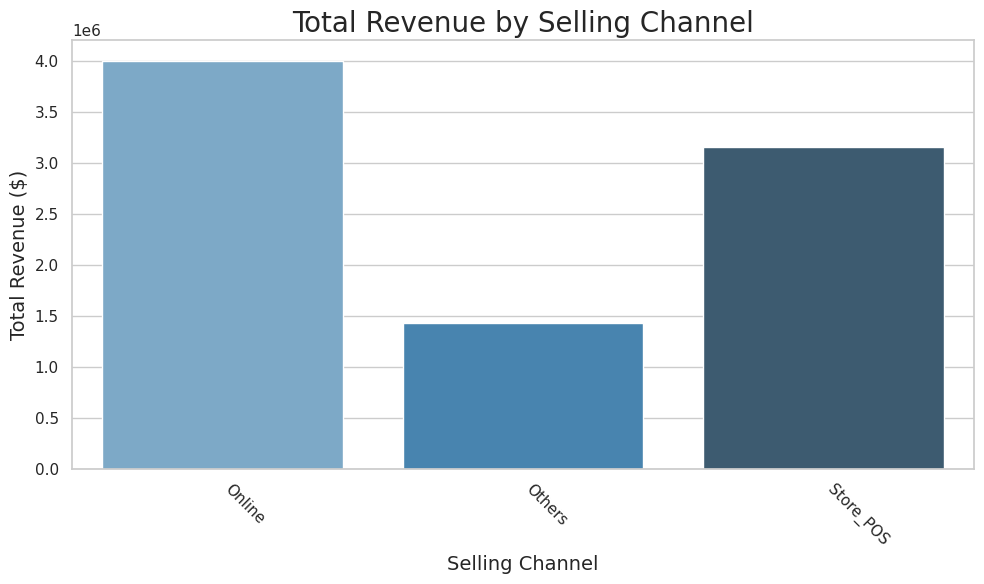

In [13]:

#  Create a new column to calculate the total revenue per order
df_sample['TOTAL_REVENUE'] = df_sample['QUANTITY'] * df_sample['UNIT_PRICE']

#  Group the data by selling channel and calculate the total revenue for each channel
channel_revenue = df_sample.groupby('SELLING_CHANNEL')['TOTAL_REVENUE'].sum().reset_index()

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Create a figure with a custom size for better visibility
plt.figure(figsize=(10, 6))

#  Create a bar plot using Seaborn to visualize the total revenue by selling channel
ax = sns.barplot(
    data=channel_revenue, 
    x='SELLING_CHANNEL', 
    y='TOTAL_REVENUE', 
    palette='Blues_d'
)

#  Add titles and axis labels to the plot
plt.title('Total Revenue by Selling Channel', fontsize=20)
plt.xlabel('Selling Channel', fontsize=14)
plt.ylabel('Total Revenue ($)', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


#  Average Unit Price by Chain

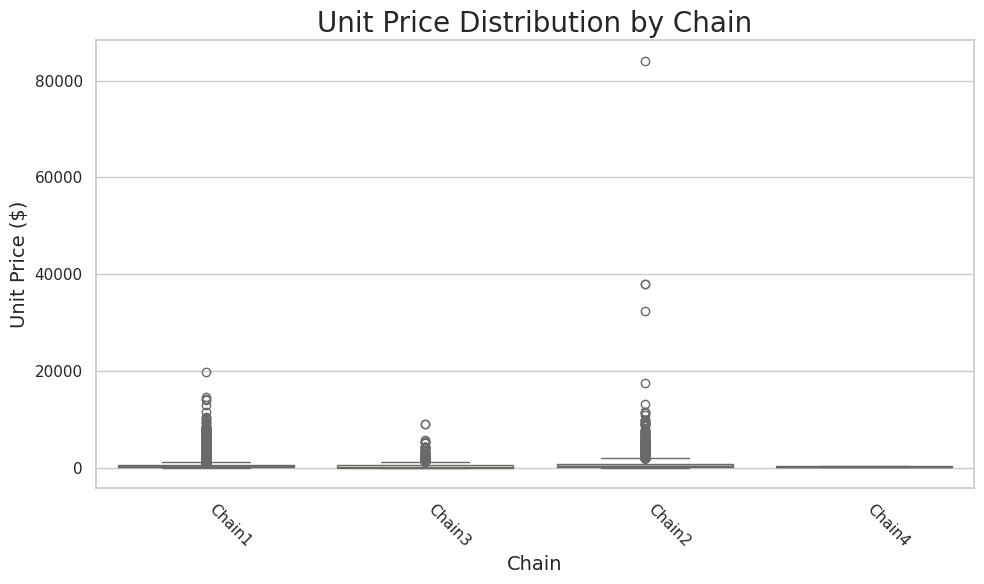

In [14]:

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

# Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

#  Create a box plot using Seaborn to visualize the distribution of unit prices by chain
sns.boxplot(
    data=df_sample, 
    x='CHAIN', 
    y='UNIT_PRICE', 
    palette='Set3'  # Use a custom color palette for visual appeal
)

#  Add titles and axis labels to the plot
plt.title('Unit Price Distribution by Chain', fontsize=20)
plt.xlabel('Chain', fontsize=14)
plt.ylabel('Unit Price ($)', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Order Size Distribution by Selling Channel

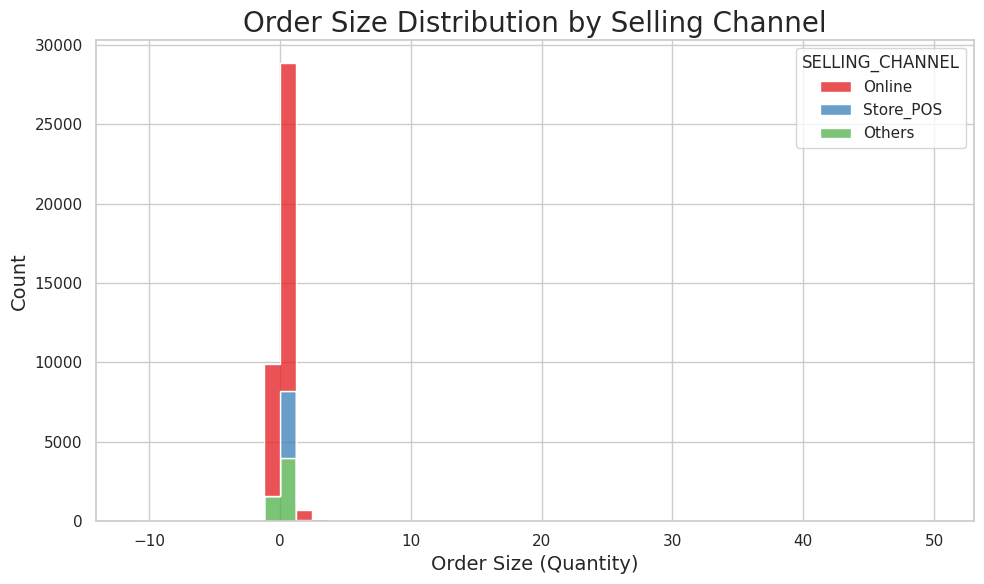

In [15]:


# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

#  Create a histogram using Seaborn's histplot with multiple selling channels
sns.histplot(
    data=df_sample, 
    x='QUANTITY', 
    hue='SELLING_CHANNEL',  # Color by selling channel
    bins=50,  # Number of bins in the histogram
    palette='Set1',  # Use a custom color palette for distinct colors
    element='step',  # Use a stepped curve for better visibility of overlap
    multiple='stack'  # Stack bars to compare the distribution across channels
)

#  Add titles and axis labels to the plot
plt.title('Order Size Distribution by Selling Channel', fontsize=20)
plt.xlabel('Order Size (Quantity)', fontsize=14)
plt.ylabel('Count', fontsize=14)

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


#  Revenue Contribution by Chain

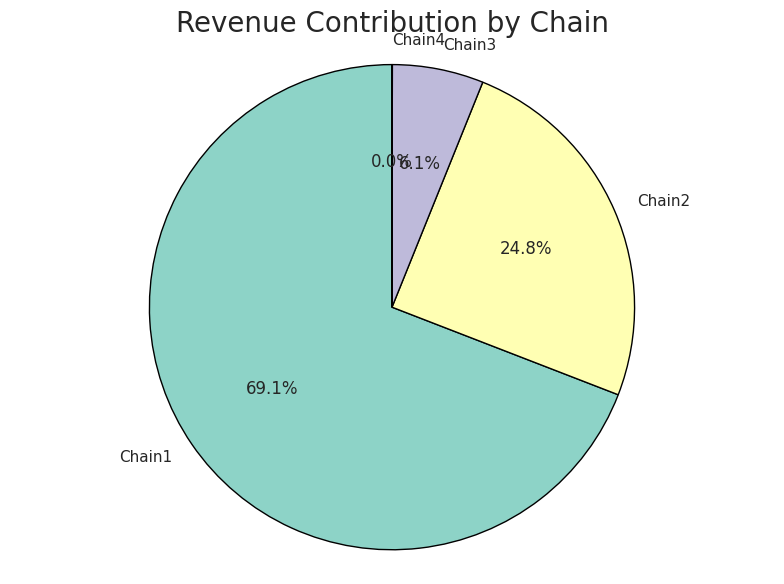

In [16]:


#  Group the data by chain and calculate the total revenue for each chain
chain_revenue = df_sample.groupby('CHAIN')['TOTAL_REVENUE'].sum().reset_index()

#  Set up the figure size for better visibility
plt.figure(figsize=(8, 6))

#  Create a pie chart using Matplotlib
plt.pie(
    chain_revenue['TOTAL_REVENUE'],  # Values for the pie chart (total revenue by chain)
    labels=chain_revenue['CHAIN'],   # Labels for each slice (chain names)
    autopct='%1.1f%%',  # Display percentage and format it to 1 decimal place
    startangle=90,      # Start the pie chart at 90 degrees for better layout
    colors=plt.cm.Set3.colors,  # Use a predefined color palette for visual appeal
    wedgeprops={'edgecolor': 'black'}  # Add a black edge to improve contrast
)

#  Add a title to the pie chart
plt.title('Revenue Contribution by Chain', fontsize=20)

#  Ensure the pie chart is displayed as a circle
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()


#  Distribution of Order Statuses

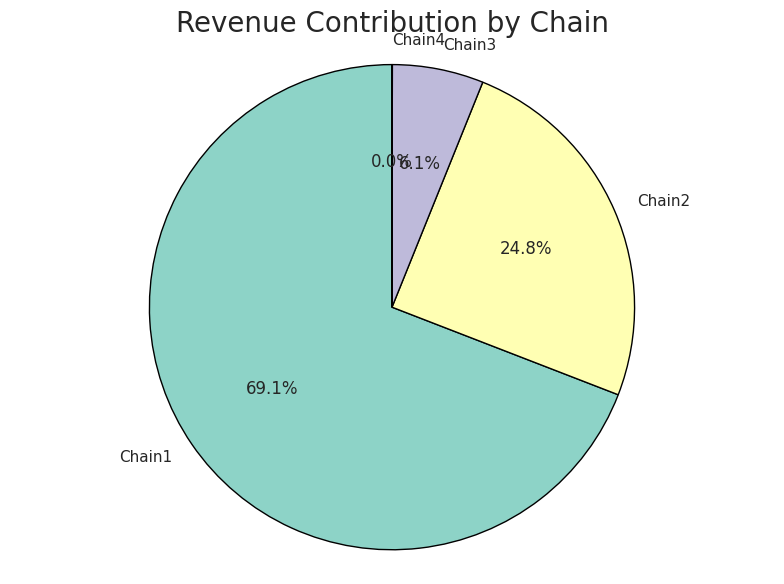

In [17]:


#  Group the data by chain and calculate the total revenue for each chain
chain_revenue = df_sample.groupby('CHAIN')['TOTAL_REVENUE'].sum().reset_index()

#  Set up the figure size for better visibility
plt.figure(figsize=(8, 6))

#  Create a pie chart using Matplotlib
plt.pie(
    chain_revenue['TOTAL_REVENUE'],  # Values for the pie chart (total revenue by chain)
    labels=chain_revenue['CHAIN'],   # Labels for each slice (chain names)
    autopct='%1.1f%%',  # Display percentage and format it to 1 decimal place
    startangle=90,      # Start the pie chart at 90 degrees for better layout
    colors=plt.cm.Set3.colors,  # Use a predefined color palette for visual appeal
    wedgeprops={'edgecolor': 'black'}  # Add a black edge to improve contrast
)

#  Add a title to the pie chart
plt.title('Revenue Contribution by Chain', fontsize=20)

#  Ensure the pie chart is displayed as a circle
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()


# Top Warehouses by Order Volume

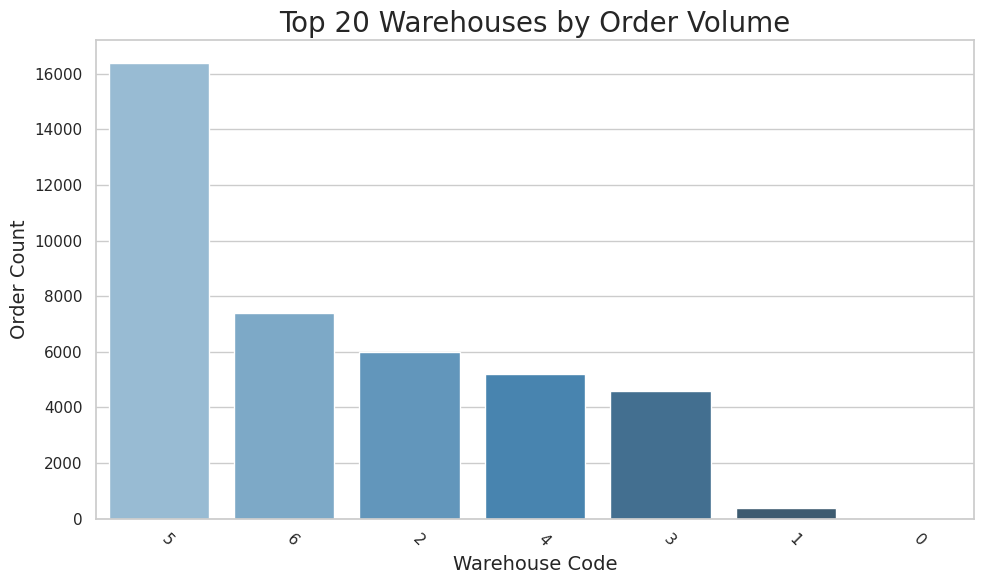

In [18]:

#  Aggregate the order counts by warehouse
warehouse_counts = df_sample['SHIP_FROM_WAREHOUSE_CODE'].value_counts().reset_index()
warehouse_counts.columns = ['SHIP_FROM_WAREHOUSE_CODE', 'Order_Count']

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

#  Create a bar plot using Seaborn to visualize the top 20 warehouses by order volume
ax = sns.barplot(
    data=warehouse_counts.head(20),  # Display top 20 warehouses
    x='SHIP_FROM_WAREHOUSE_CODE', 
    y='Order_Count', 
    palette='Blues_d'  # Use a color palette for visual appeal
)

#  Add titles and axis labels to the plot
plt.title('Top 20 Warehouses by Order Volume', fontsize=20)
plt.xlabel('Warehouse Code', fontsize=14)
plt.ylabel('Order Count', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Order Status by Warehouse

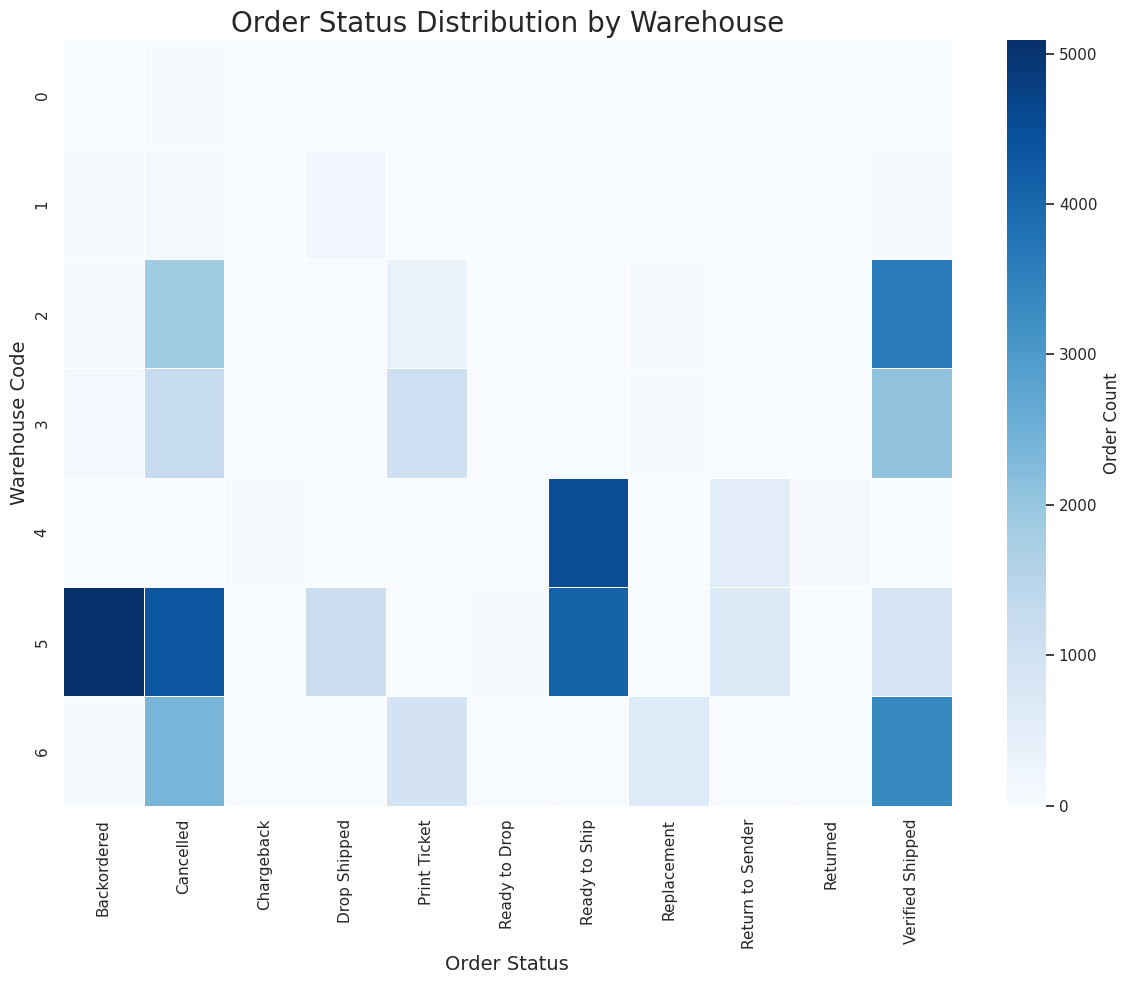

In [19]:


# Create a pivot table to aggregate order counts by warehouse and status
warehouse_status = df_sample.pivot_table(
    index='SHIP_FROM_WAREHOUSE_CODE', 
    columns='CURRENT_STATUS', 
    values='WEB_ORDER_NUMBER', 
    aggfunc='count'
).fillna(0)

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Set up the figure size for better visibility
plt.figure(figsize=(12, 10))

#  Create a heatmap using Seaborn to visualize the distribution of order statuses by warehouse
sns.heatmap(
    warehouse_status, 
    cmap='Blues',  # Use a blue color palette for visual appeal
    annot=False,   # Disable annotations inside the heatmap cells (change to True if you want to show values)
    linewidths=0.5,  # Add space between cells for better clarity
    cbar_kws={'label': 'Order Count'}  # Add a color bar to indicate the scale of order counts
)

# Add titles and axis labels to the plot
plt.title('Order Status Distribution by Warehouse', fontsize=20)
plt.xlabel('Order Status', fontsize=14)
plt.ylabel('Warehouse Code', fontsize=14)

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Cancellation Rate by Warehouse

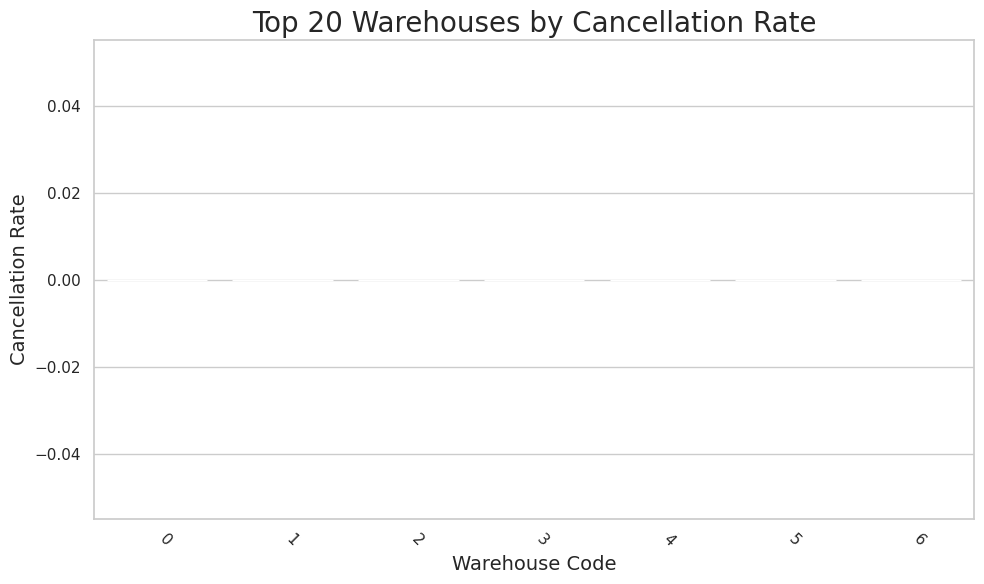

In [20]:
#  Create a new column indicating whether an order was cancelled (1 for cancelled, 0 otherwise)
df_sample['CANCELLED_FLAG'] = df_sample['CURRENT_STATUS'].apply(lambda x: 1 if x == 'CX' else 0)

#  Group the data by warehouse and calculate the cancellation rate for each warehouse
cancellation_rate = df_sample.groupby('SHIP_FROM_WAREHOUSE_CODE')['CANCELLED_FLAG'].mean().reset_index()
cancellation_rate.columns = ['SHIP_FROM_WAREHOUSE_CODE', 'Cancellation_Rate']

# Sort the warehouses by cancellation rate and select the top 20
top_warehouses = cancellation_rate.sort_values(by='Cancellation_Rate', ascending=False).head(20)

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

#  Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a bar plot using Seaborn to visualize the top 20 warehouses by cancellation rate
ax = sns.barplot(
    data=top_warehouses, 
    x='SHIP_FROM_WAREHOUSE_CODE', 
    y='Cancellation_Rate', 
    palette='Reds_d'  # Use a red color palette to represent cancellation rates
)

# Add titles and axis labels to the plot
plt.title('Top 20 Warehouses by Cancellation Rate', fontsize=20)
plt.xlabel('Warehouse Code', fontsize=14)
plt.ylabel('Cancellation Rate', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=-45, ha='left')

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Order Volume Over Time

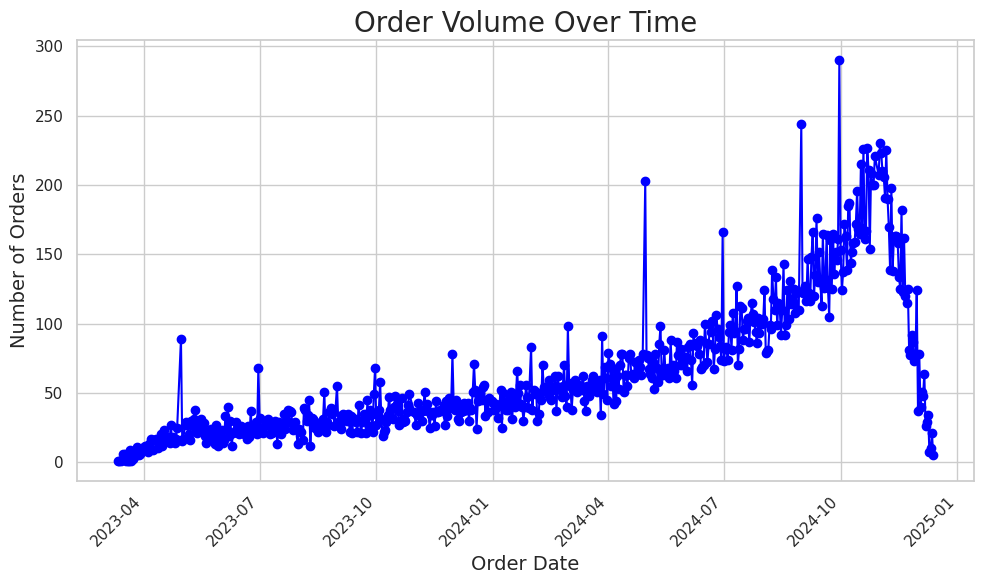

In [21]:

# Aggregate order volume by order date
order_volume = df_sample.groupby('ORDER_DATE').size().reset_index(name='Order_Count')

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

# Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a line plot using Seaborn or Matplotlib to visualize order volume over time
plt.plot(
    order_volume['ORDER_DATE'],  # x-axis (order dates)
    order_volume['Order_Count'],  # y-axis (number of orders)
    color='blue', 
    marker='o', 
    linestyle='-', 
    label='Order Count'
)

#  Add titles and axis labels to the plot
plt.title('Order Volume Over Time', fontsize=20)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Time Between Order Creation and Confirmation

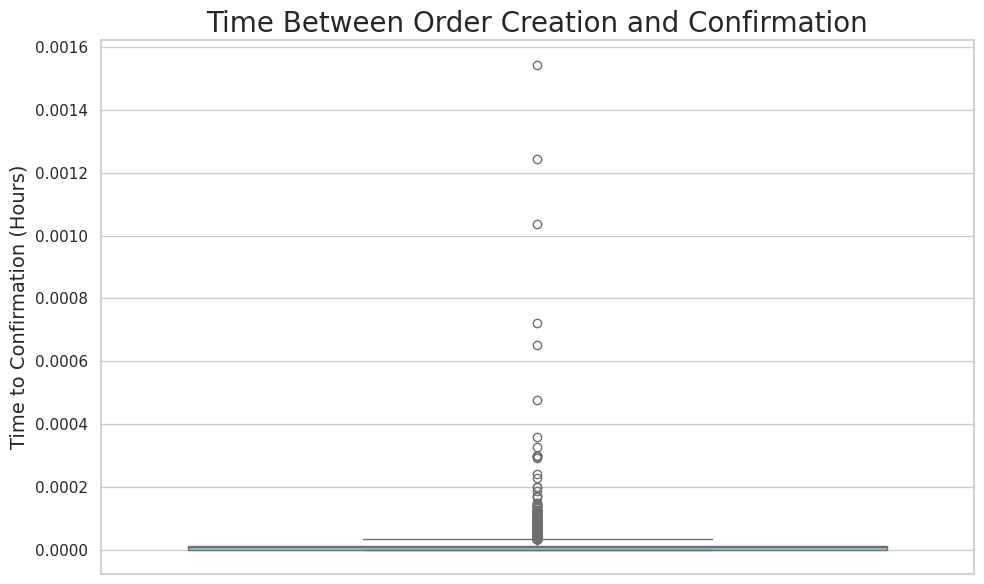

In [22]:

# Convert the order creation and confirmation dates, handling errors for inconsistent formats
df_sample['ORDER_CREATION_DATE'] = pd.to_datetime(df_sample['ORDER_CREATION_DATE'], errors='coerce')
df_sample['ORDER_CONFIRMATION_DATE'] = pd.to_datetime(df_sample['ORDER_CONFIRMATION_DATE'], errors='coerce')

#  Calculate the time difference between order creation and confirmation (in hours)
df_sample['TIME_TO_CONFIRMATION'] = (df_sample['ORDER_CONFIRMATION_DATE'] - df_sample['ORDER_CREATION_DATE']).dt.total_seconds() / 3600

#  Filter out rows where the time difference is NaN (invalid date calculations)
df_sample = df_sample[df_sample['TIME_TO_CONFIRMATION'].notna()]

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

# Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

#  Create a box plot using Seaborn to visualize the time between order creation and confirmation
sns.boxplot(
    data=df_sample,
    y='TIME_TO_CONFIRMATION',  # Time to confirmation (in hours)
    color='skyblue'  # Use a specific color for the box plot
)

# Add titles and axis labels to the plot
plt.title('Time Between Order Creation and Confirmation', fontsize=20)
plt.ylabel('Time to Confirmation (Hours)', fontsize=14)

#  Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()


# Backorder Trends Over Time

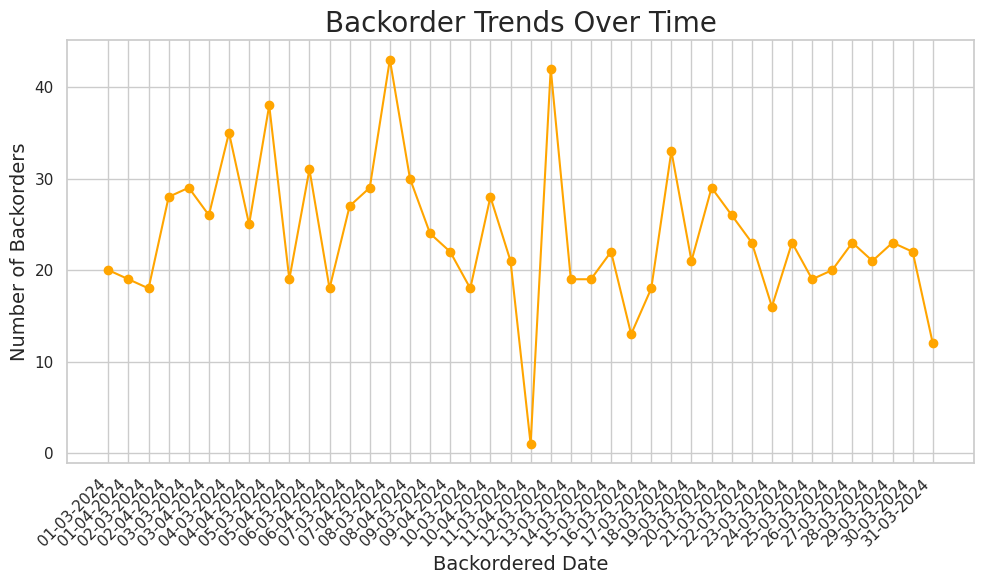

In [23]:
#Filter out rows where 'BACK_ORDERED_DATE' is NaN and aggregate backorder counts by date
backorder_trends = df_sample[df_sample['BACK_ORDERED_DATE'].notna()].groupby('BACK_ORDERED_DATE').size().reset_index(name='Backorder_Count')

# Set the Seaborn style for a clean visual
sns.set(style="whitegrid")

# Set up the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a line plot using Matplotlib to visualize backorder trends over time
plt.plot(
    backorder_trends['BACK_ORDERED_DATE'],  # x-axis (backordered dates)
    backorder_trends['Backorder_Count'],  # y-axis (number of backorders)
    color='orange',  # Use orange for the line color
    marker='o',  # Use circle markers for each point
    linestyle='-',  # Solid line style
    label='Backorder Count'
)

# Add titles and axis labels to the plot
plt.title('Backorder Trends Over Time', fontsize=20)
plt.xlabel('Backordered Date', fontsize=14)
plt.ylabel('Number of Backorders', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()
